In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [11]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def run_pred(clf_name, X_train, y_train, X_test, y_test):
    accus = []
    for i in range(5):
        seed = 21 + i*93940
        if clf_name == 'LR':
            clf = LogisticRegression(random_state=seed, max_iter=1000)
        elif clf_name == 'MLP':
            clf = MLPClassifier(
                [32, 32], batch_size = 128, random_state=seed, alpha = 0.001, max_iter = 1000)
        else:
            raise ValueError('clf_name should be LR or MLP')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accus.append(metrics.accuracy_score(y_test, y_pred))
    return np.mean(accus), np.std(accus)

def sklearn_evaluation(rets):

    original_data = rets['data']['origin_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    centralized_data = rets['data']['imputed_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    test_data = rets['data']['test_data']

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized LR:{:.4f} ({:.3f})".format(accu, std))

    X_train = original_data[:, :-1]
    y_train = original_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))


In [13]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    "scale_factor": 4
  }
}

## Simulation

## MARY - Naive Avgerage

### simulate missing

In [6]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 60
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_left' 'mary_left' 'mary_left' 'mary_left'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right']


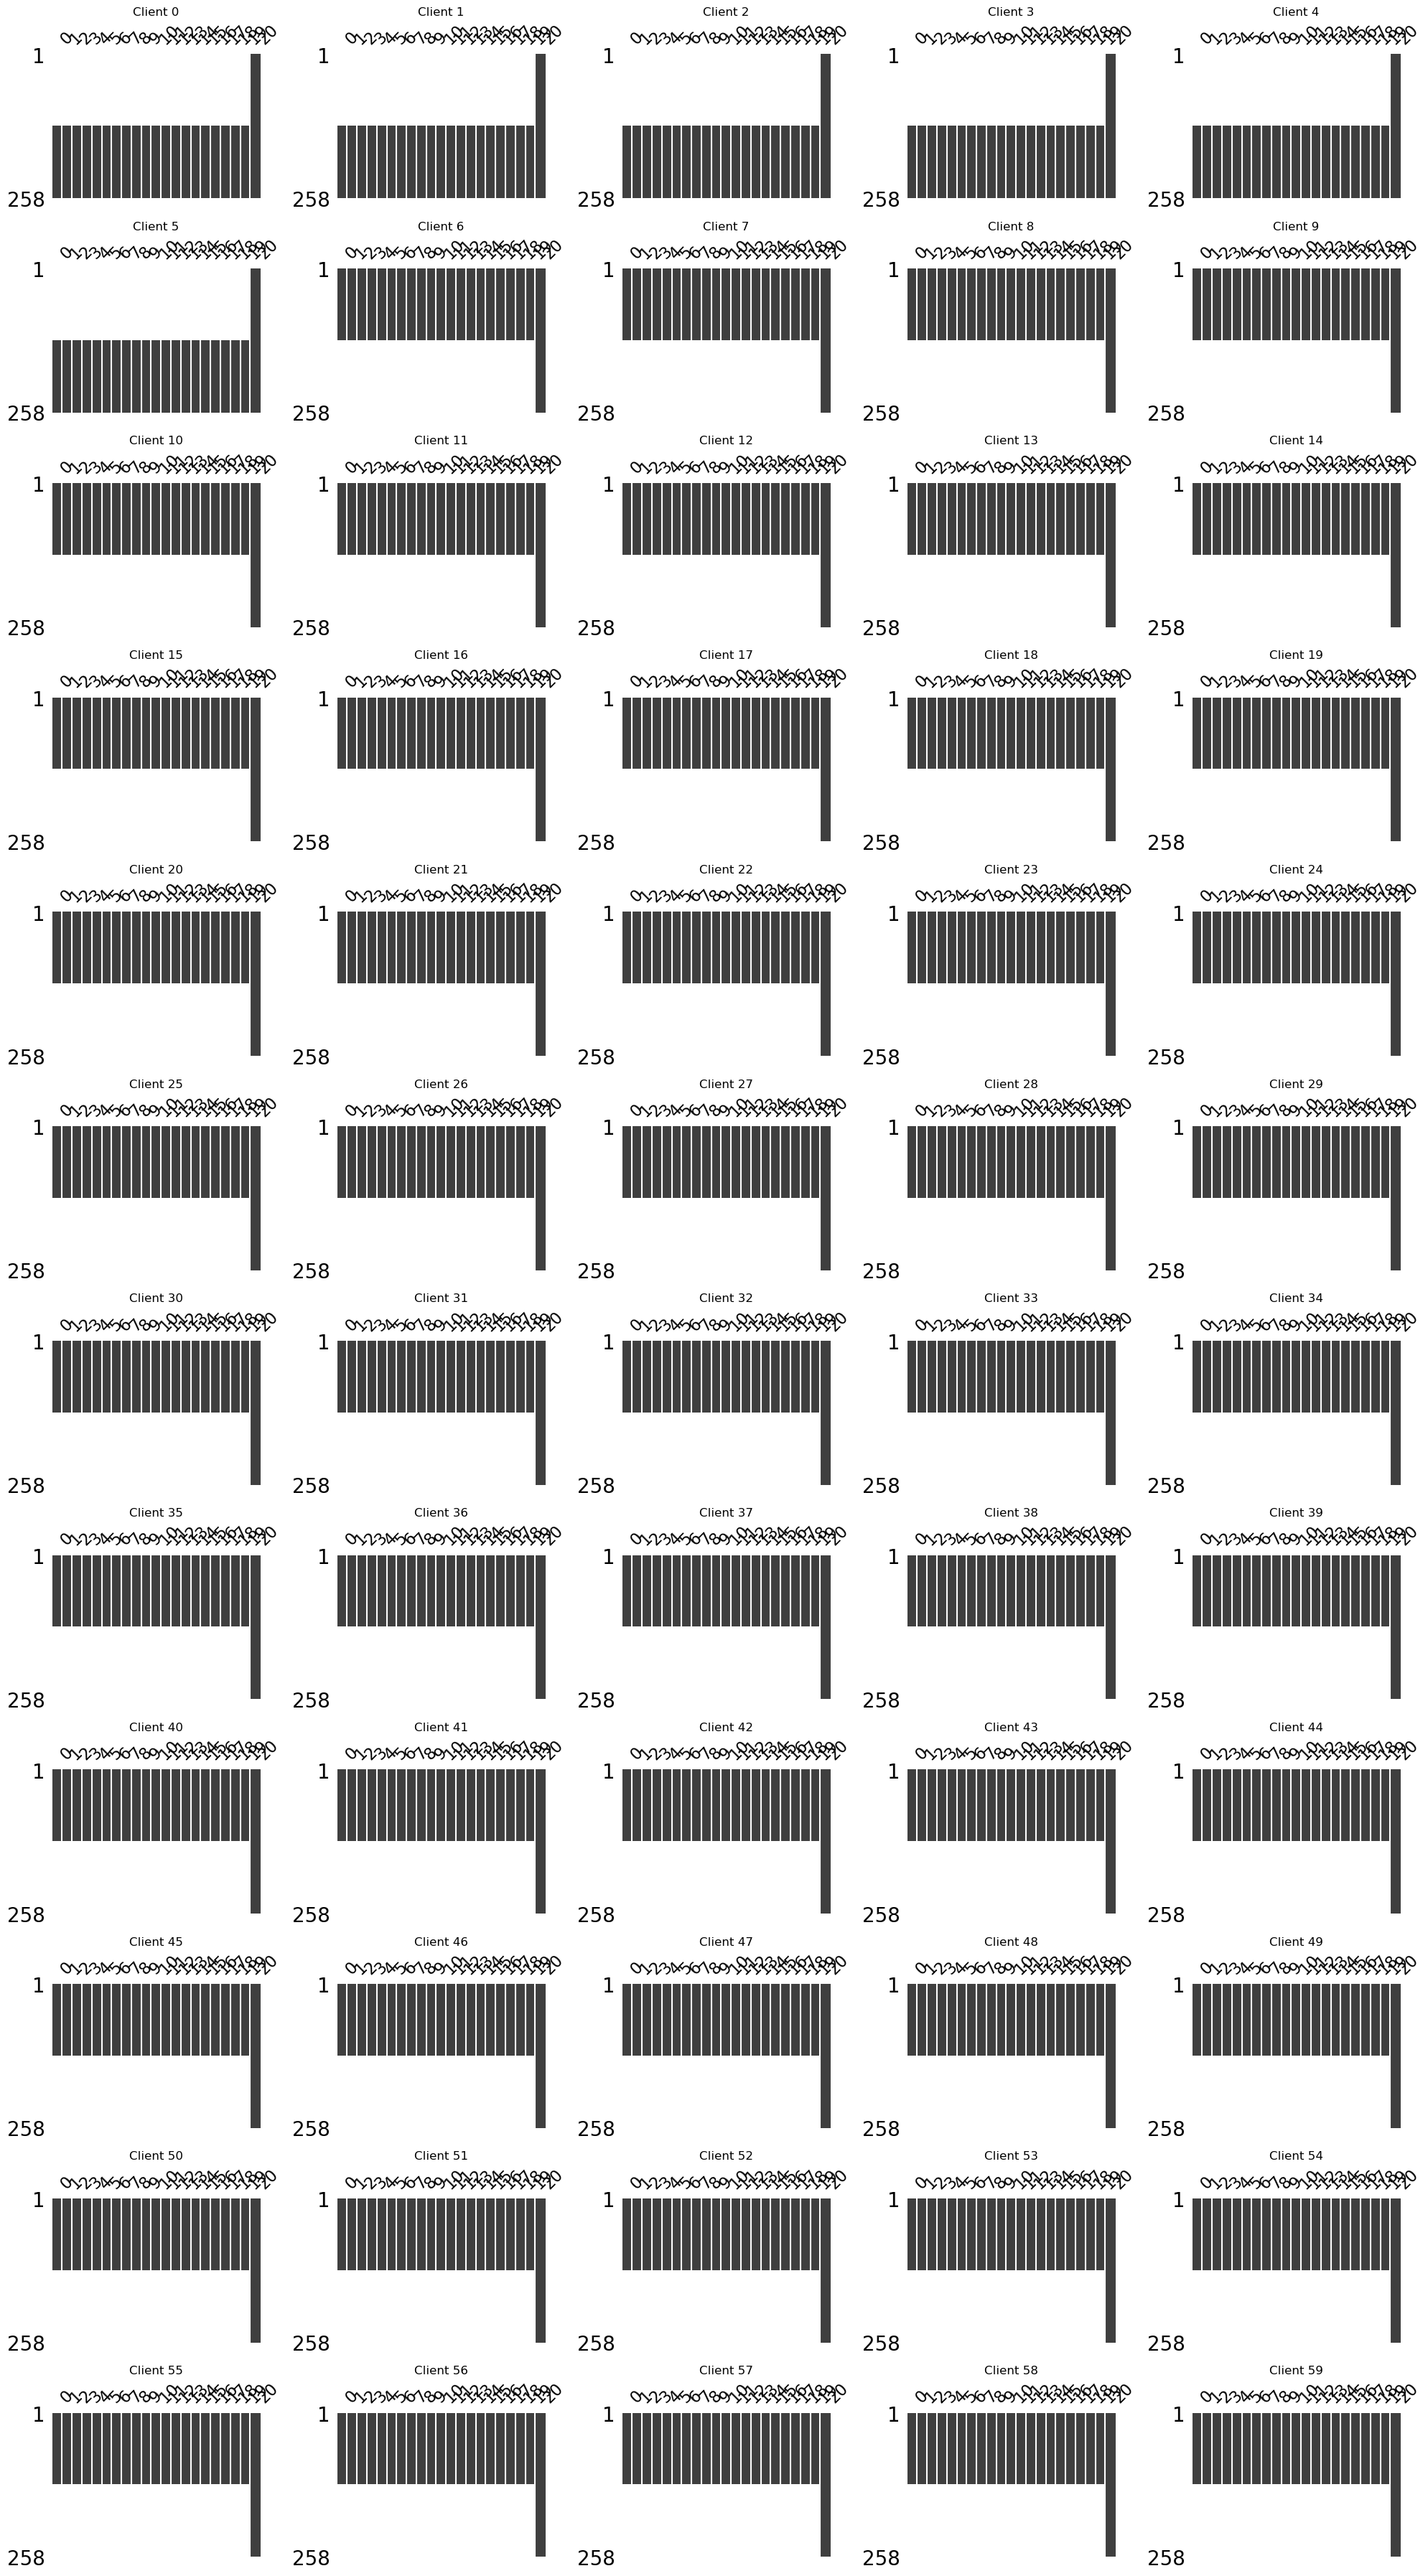

In [7]:
visualize_ms(data_ms_clients)

### Federated Imputation

In [8]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret = server.run()

2023-07-19 01:05:59.086 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 557.6400434000534


In [9]:
ret['data']['origin_data'].shape

(60, 258, 21)

In [10]:
original_data = ret['data']['origin_data'].reshape(-1, 21)
print(original_data.shape)
centralized_data = ret['data']['imputed_data'].reshape(-1, 21)
print(centralized_data.shape)
test_data = ret['data']['test_data']
print(test_data.shape)
print(ret['imp_result'])

(15480, 21)
(15480, 21)
(11051, 21)
{'imp@rmse': 0.1974363292958548, 'imp@ws': 1.4304929121183072, 'imp@sliced_ws': 0.09477596646515342}


In [11]:
correlation(original_data, centralized_data)

20    1.000000
18    0.456583
16    0.367031
15    0.354198
14    0.213883
11    0.109533
12    0.092952
13    0.071447
4     0.056788
2     0.042460
1     0.039126
19    0.027650
3     0.027314
10    0.023167
0     0.019631
17    0.010520
7     0.007385
9     0.004551
5     0.004046
8     0.001266
6     0.000734
dtype: float64
20    1.000000
18    0.134680
15    0.110788
16    0.097954
14    0.057830
10    0.052271
12    0.032672
11    0.028746
0     0.023356
13    0.017419
4     0.017167
19    0.015071
1     0.013586
8     0.010462
6     0.008319
7     0.006686
2     0.005240
5     0.004858
9     0.003862
3     0.003163
17    0.001856
dtype: float64


### Evaluation FedAvg Our Implementation

In [13]:
server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [14]:
clients = {}
data_imp = ret['data']['imputed_data']
missing_mask = ret['data']['missing_mask']
data_true = ret['data']['origin_data']
n_clients = ret['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret = server.prediction()

2023-07-19 01:11:14.877 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5001, test_f1: 0.3339, val_loss: 0.3630, val_accu: 0.8994, val_f1: 0.8994
2023-07-19 01:12:52.117 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.4815, val_accu: 0.9000, val_f1: 0.9000
2023-07-19 01:14:29.755 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.4997, val_accu: 0.9000, val_f1: 0.9000
2023-07-19 01:16:07.281 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.5189, val_accu: 0.9000, val_f1: 0.9000
2023-07-19 01:17:44.122 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5000, test_f1: 0.333

In [16]:
pred_ret

{'accu_mean': 0.915482761741019,
 'f1_mean': 0.9152353842947754,
 'accu_std': 0.0,
 'f1_std': 0.0}

## MARY - Use complementary Models

In [17]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 60
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_left' 'mary_left' 'mary_left' 'mary_left'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right']


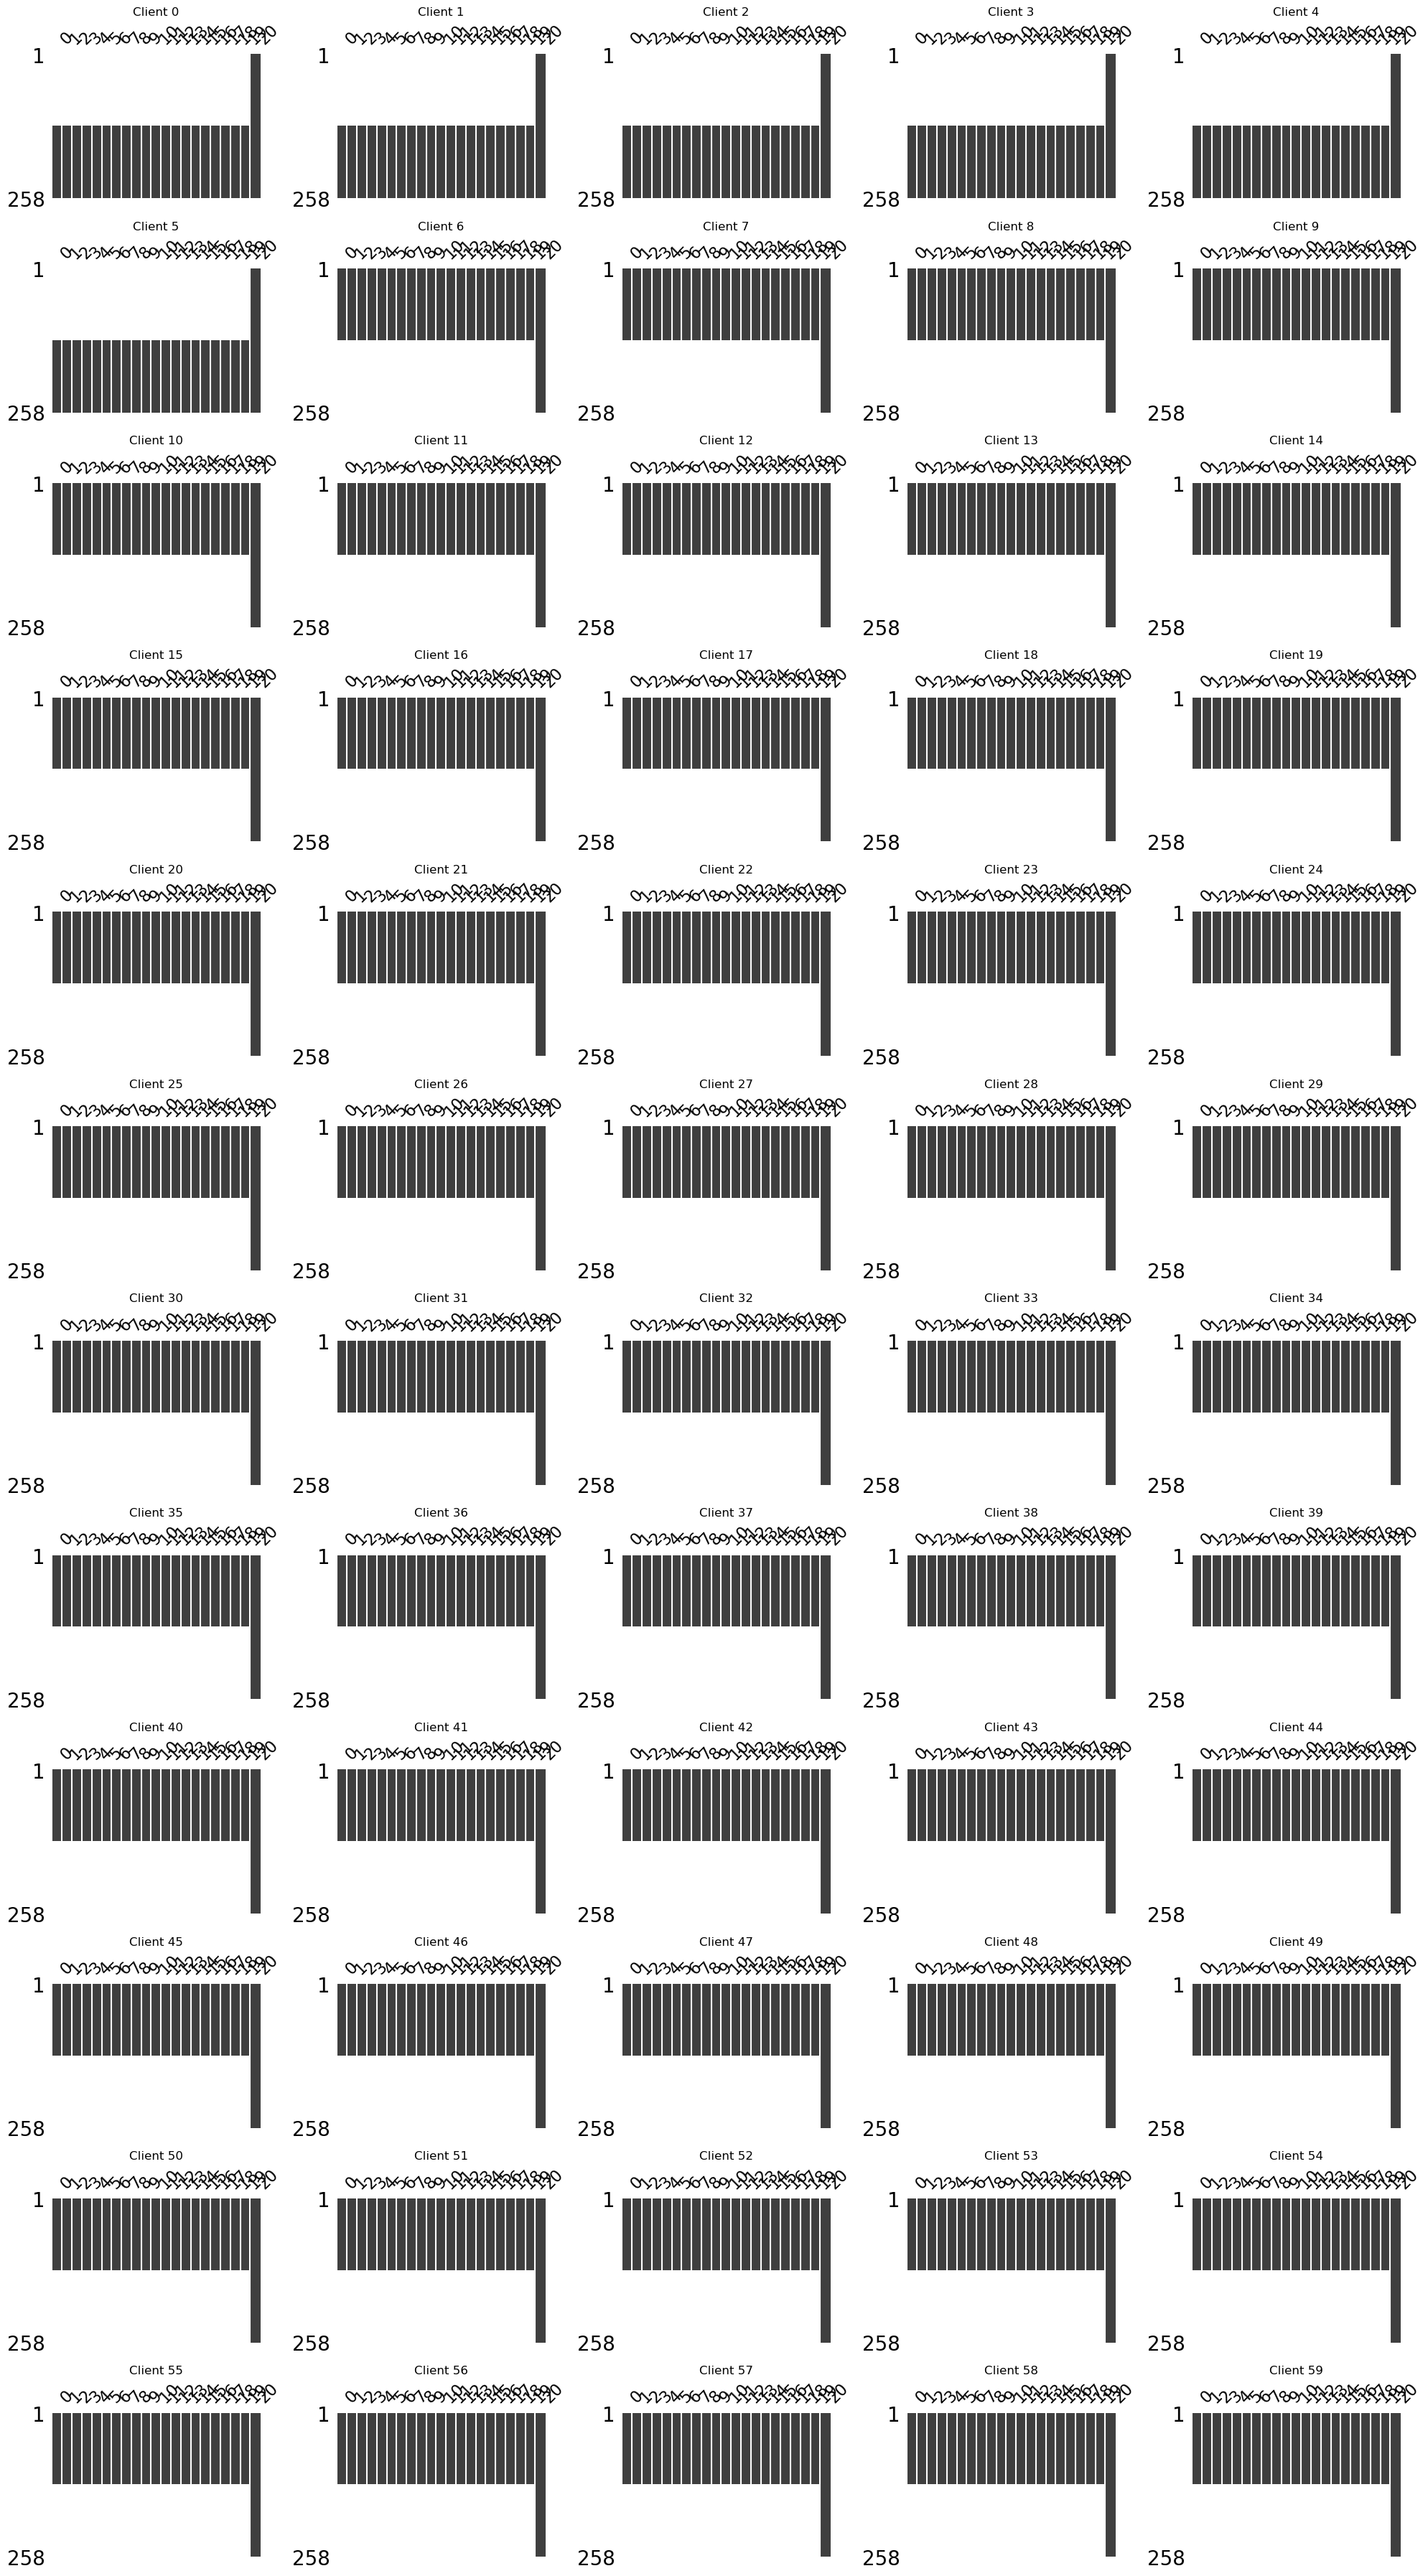

In [18]:
visualize_ms(data_ms_clients)

In [19]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret3 = server.run()

testavg


2023-07-19 01:38:58.737 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 557.0717336999951


In [20]:
original_data3 = ret3['data']['origin_data'].reshape(-1, ret3['data']['origin_data'].shape[-1])
print(original_data.shape)
centralized_data3 = ret3['data']['imputed_data'].reshape(-1, ret3['data']['imputed_data'].shape[-1])
print(centralized_data.shape)
test_data3 = ret3['data']['test_data']
print(test_data.shape)
ret3['imp_result']

(15480, 21)
(15480, 21)
(11051, 21)


{'imp@rmse': 0.1967580159040582,
 'imp@ws': 1.4169262157344715,
 'imp@sliced_ws': 0.0940940142425625}

In [21]:
correlation(original_data3, centralized_data3)

20    1.000000
18    0.456583
16    0.367031
15    0.354198
14    0.213883
11    0.109533
12    0.092952
13    0.071447
4     0.056788
2     0.042460
1     0.039126
19    0.027650
3     0.027314
10    0.023167
0     0.019631
17    0.010520
7     0.007385
9     0.004551
5     0.004046
8     0.001266
6     0.000734
dtype: float64
20    1.000000
18    0.608781
15    0.519054
16    0.489091
14    0.296833
12    0.158387
11    0.149461
13    0.105758
4     0.092451
19    0.080557
6     0.059593
8     0.053801
1     0.036483
7     0.033043
10    0.027837
9     0.020767
0     0.019858
3     0.017169
2     0.011454
5     0.009315
17    0.000902
dtype: float64


In [22]:
sklearn_evaluation(ret3)

Accuracy imputed centralized MLP:0.8882 (0.025)
Accuracy imputed centralized LR:0.8155 (0.000)
Accuracy orignal centralized MLP:0.9517 (0.003)
Accuracy orignal centralized MLP:0.8721 (0.000)


In [23]:
clients = {}
data_imp = ret3['data']['imputed_data']
missing_mask = ret3['data']['missing_mask']
data_true = ret3['data']['origin_data']
n_clients = ret3['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data3
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data3
    )

pred_ret = server.prediction()

2023-07-19 01:45:24.341 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5095, test_f1: 0.3546, val_loss: 0.2275, val_accu: 0.9010, val_f1: 0.9010
2023-07-19 01:47:01.088 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.5094, test_f1: 0.3537, val_loss: 0.2851, val_accu: 0.9013, val_f1: 0.9013
2023-07-19 01:48:38.521 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.5056, test_f1: 0.3455, val_loss: 0.3130, val_accu: 0.9010, val_f1: 0.9010
2023-07-19 01:50:15.153 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5028, test_f1: 0.3394, val_loss: 0.3422, val_accu: 0.9006, val_f1: 0.9006
2023-07-19 01:51:54.166 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5013, test_f1: 0.336

In [24]:
clients = {}
data_imp = ret3['data']['imputed_data']
missing_mask = ret3['data']['missing_mask']
data_true = ret3['data']['origin_data']
n_clients = ret3['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data3
    )

pred_config = server_config_tmpl.copy()
server_name = 'central_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data3
    )

pred_ret = server.prediction()

2023-07-19 01:58:22.923 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5573, train_loss: 0.6624 val_accu: 0.8561 val_f1: 0.8555
2023-07-19 01:58:25.875 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 10, test_accu: 0.6614, train_loss: 0.1114 val_accu: 0.9638 val_f1: 0.9638
2023-07-19 01:58:28.812 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 20, test_accu: 0.6886, train_loss: 0.0986 val_accu: 0.9663 val_f1: 0.9663
2023-07-19 01:58:31.774 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 30, test_accu: 0.6811, train_loss: 0.0932 val_accu: 0.9663 val_f1: 0.9663
2023-07-19 01:58:34.730 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 40, test_accu: 0.7438, train_loss: 0.0886 val_accu: 0.9692 val_f1: 0.9692
2023-07-19 01:58:37.715 | INFO 

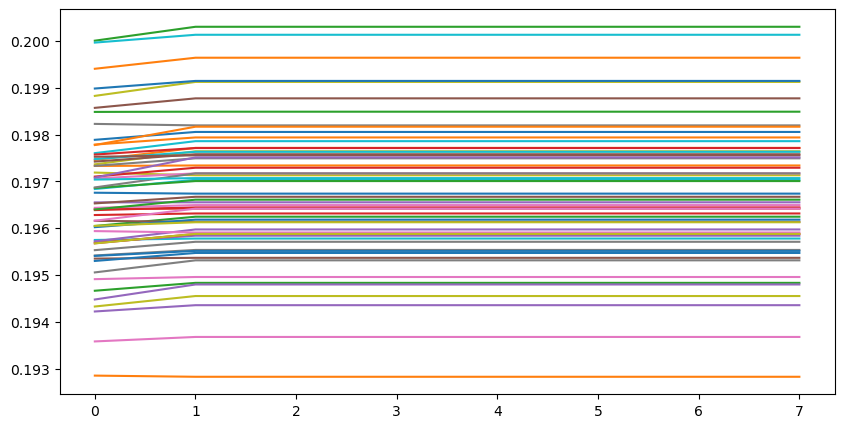

In [25]:
x = list(range(len(ret3['client_imp_history'])))
client_ids = list(ret3['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret3['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

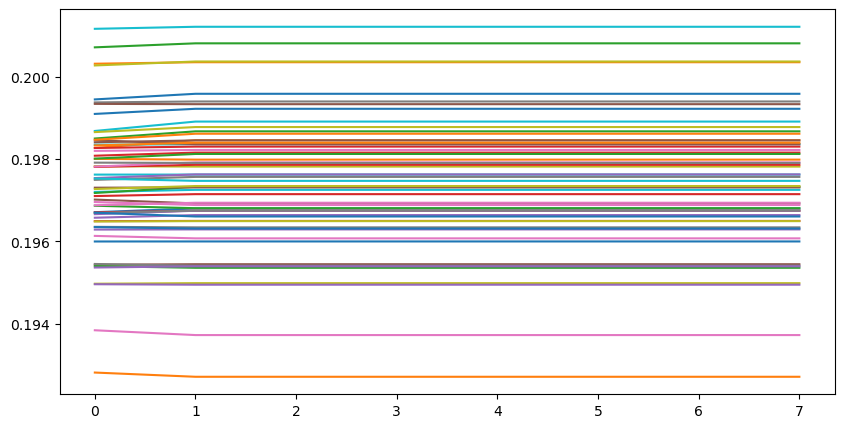

In [26]:
x = list(range(len(ret['client_imp_history'])))
client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

## MNAR LR

In [59]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 60
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'm

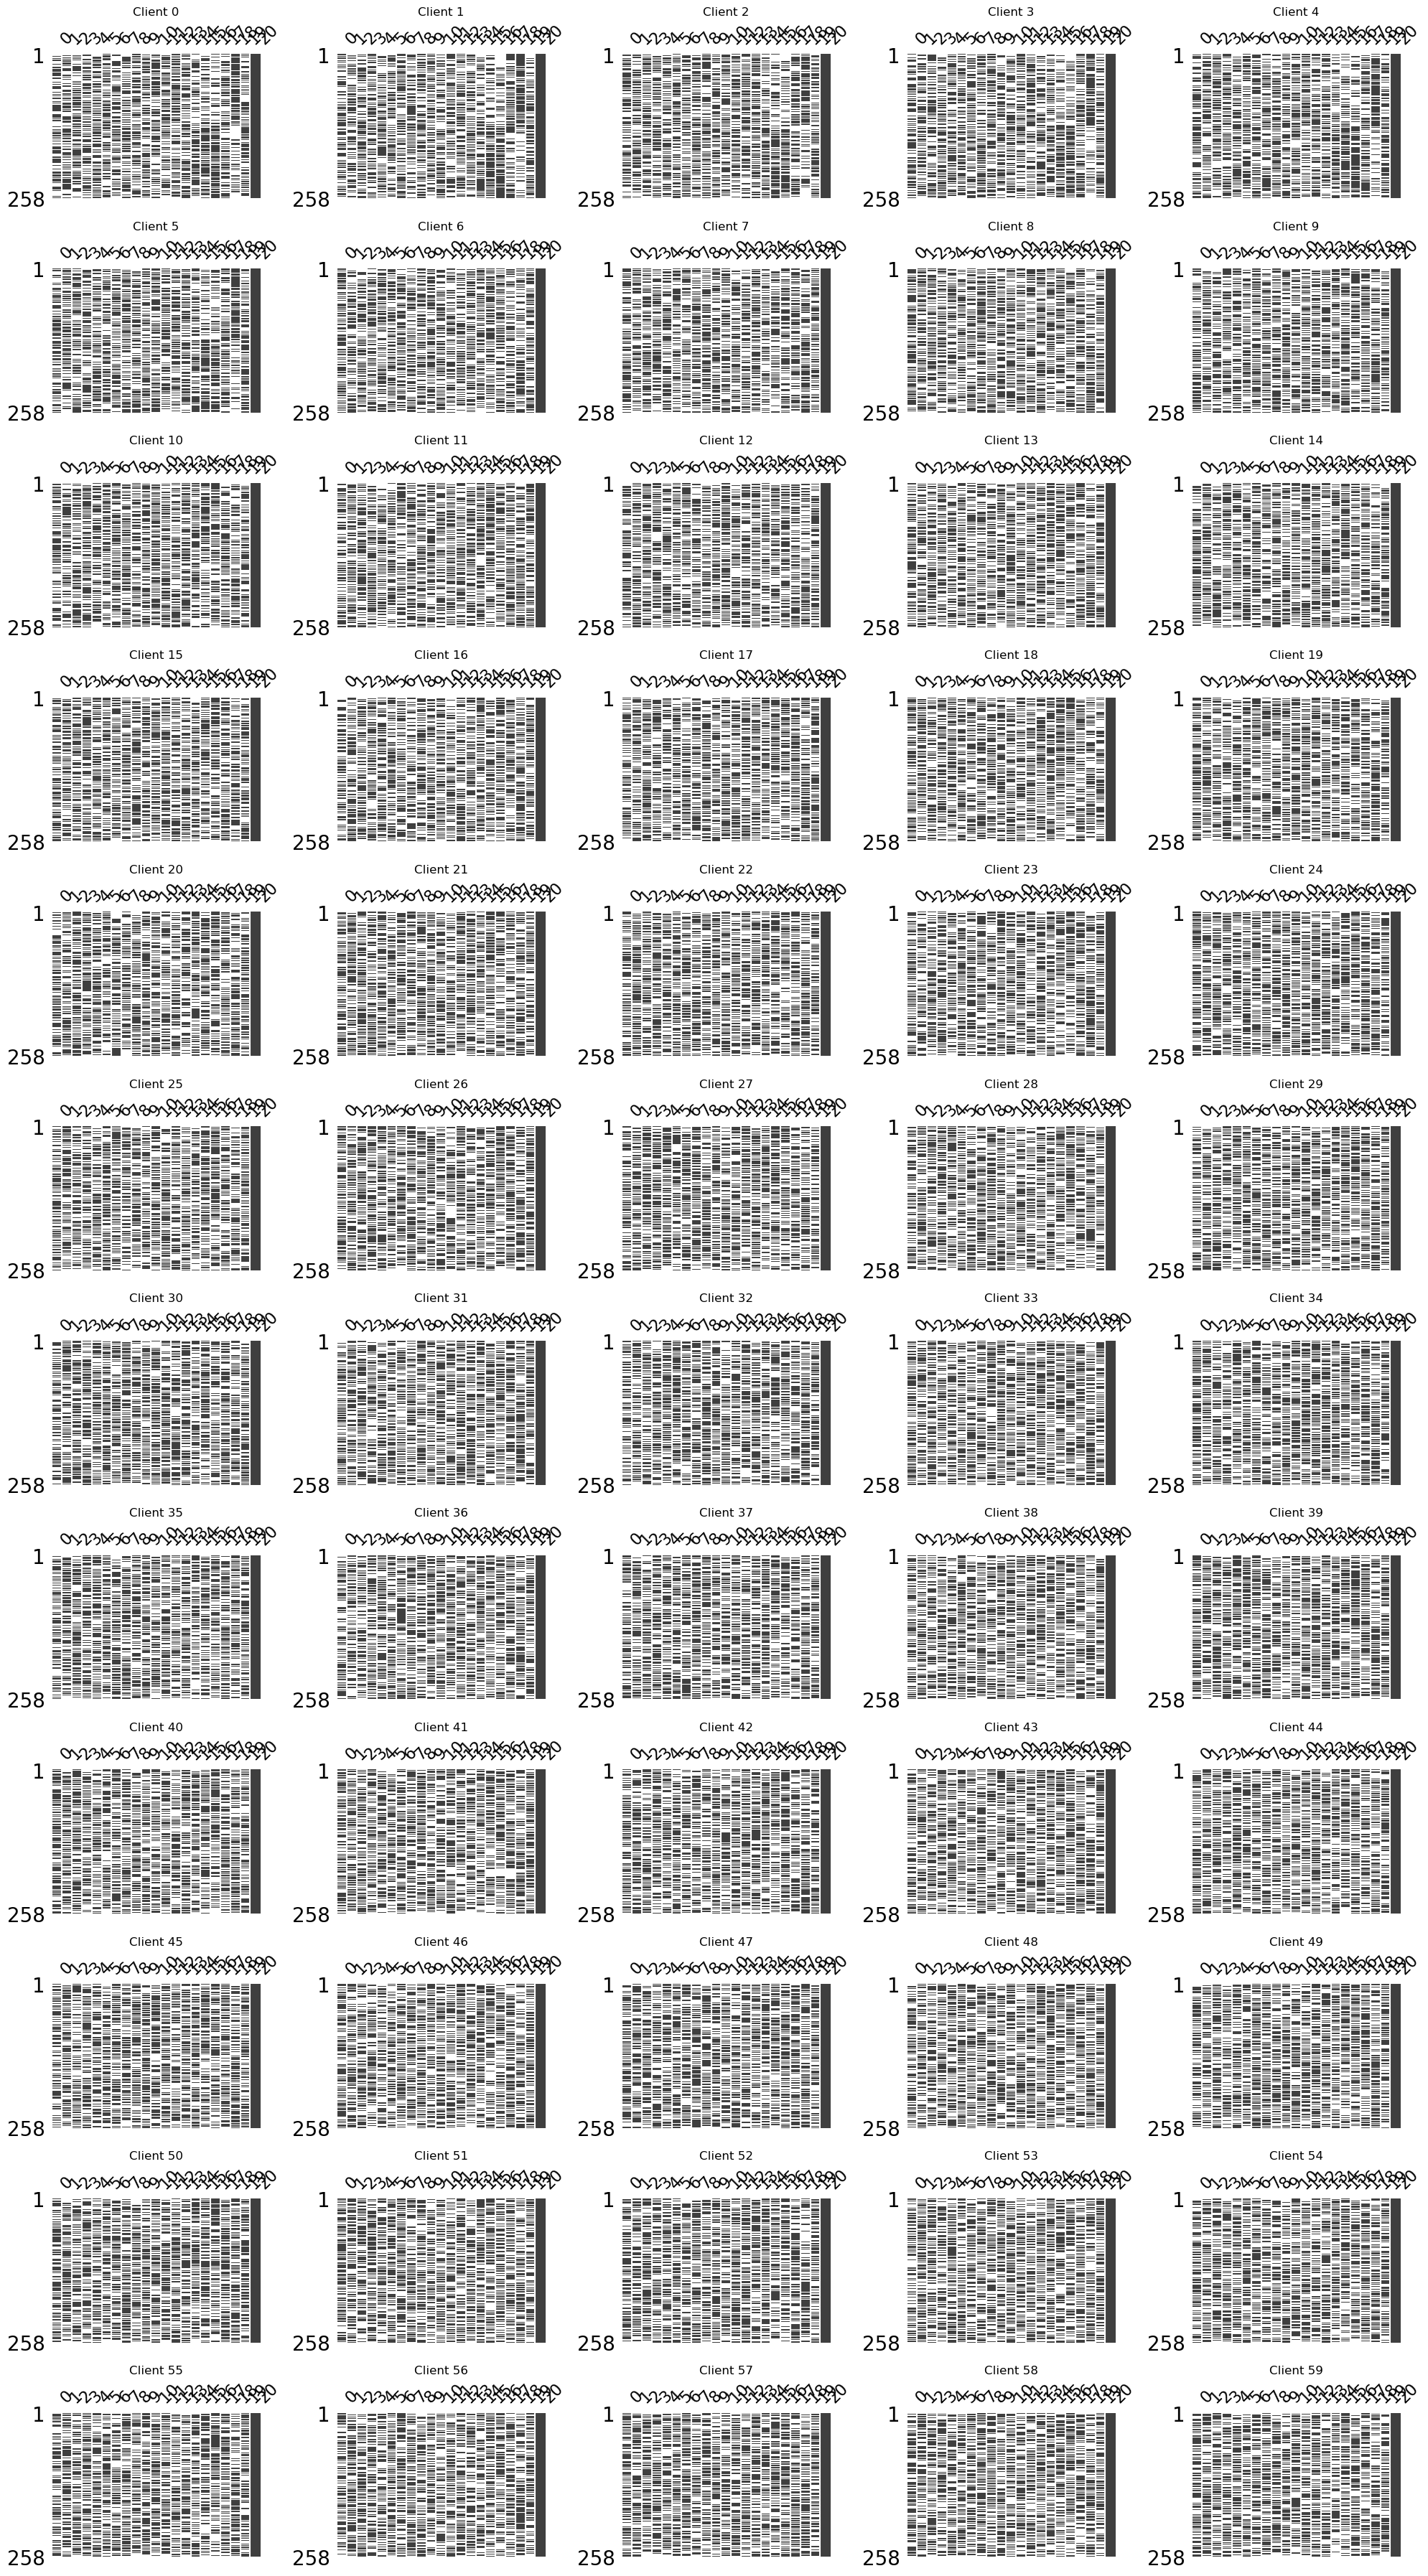

In [28]:
visualize_ms(data_ms_clients2)

### Simple Average

In [30]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret2 = server.run()

2023-07-19 02:12:59.842 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 548.7555180999916


In [31]:
original_data2 = ret2['data']['origin_data'].reshape(-1, ret2['data']['origin_data'].shape[-1])
print(original_data2.shape)
centralized_data2 = ret2['data']['imputed_data'].reshape(-1, ret2['data']['imputed_data'].shape[-1])
print(centralized_data2.shape)
test_data2 = ret2['data']['test_data']
print(test_data2.shape)
print(ret2['imp_result'])

x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

(15480, 21)
(15480, 21)
(11051, 21)
{'imp@rmse': 0.22657682434336465, 'imp@ws': 0.9494990158966077, 'imp@sliced_ws': 0.07046942207252462}


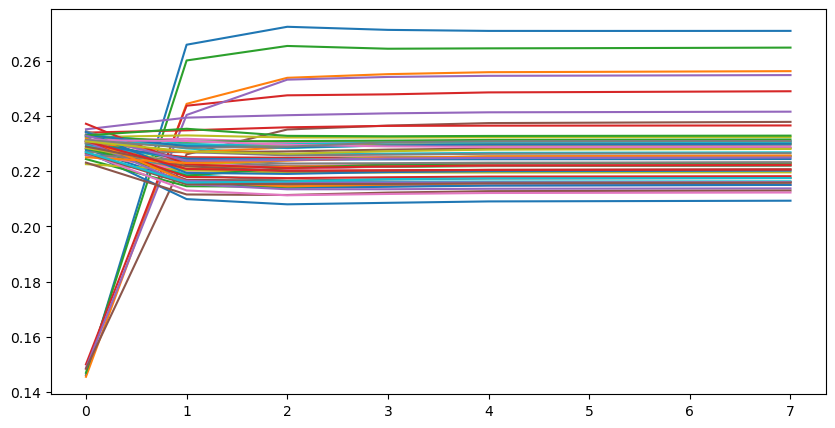

In [32]:
x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [33]:
sklearn_evaluation(ret2)

Accuracy imputed centralized MLP:0.8041 (0.013)
Accuracy imputed centralized LR:0.7888 (0.000)
Accuracy orignal centralized MLP:0.9517 (0.003)
Accuracy orignal centralized MLP:0.8721 (0.000)


In [36]:
clients = {}
data_imp2 = ret2['data']['imputed_data']
missing_mask2 = ret2['data']['missing_mask']
data_true2 = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data2
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data2
    )

pred_ret2 = server.prediction()

2023-07-19 02:22:46.448 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8235, test_f1: 0.8232, val_loss: 0.6130, val_accu: 0.6747, val_f1: 0.6741
2023-07-19 02:24:23.601 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8418, test_f1: 0.8415, val_loss: 0.5772, val_accu: 0.6984, val_f1: 0.6981
2023-07-19 02:26:01.147 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8392, test_f1: 0.8390, val_loss: 0.5699, val_accu: 0.7032, val_f1: 0.7030
2023-07-19 02:27:38.918 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8305, test_f1: 0.8304, val_loss: 0.5660, val_accu: 0.7048, val_f1: 0.7044
2023-07-19 02:29:15.924 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8284, test_f1: 0.828

### Complementary Models

In [37]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 60
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'm

In [38]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret4 = server.run()

testavg


2023-07-19 02:45:12.452 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 553.5131046999595


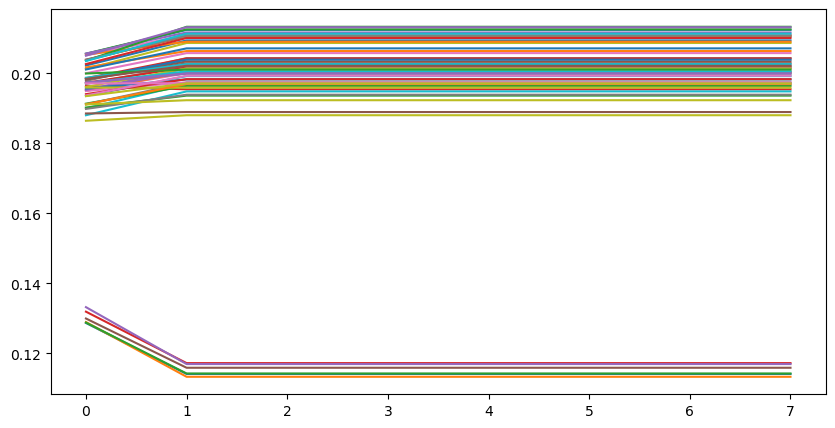

In [39]:
x = list(range(len(ret4['client_imp_history'])))
client_ids = list(ret4['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret4['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [40]:
original_data4 = ret4['data']['origin_data'].reshape(-1, ret4['data']['origin_data'].shape[-1])
print(original_data4.shape)
centralized_data4 = ret4['data']['imputed_data'].reshape(-1, ret4['data']['imputed_data'].shape[-1])
print(centralized_data4.shape)
test_data4 = ret4['data']['test_data']
print(test_data4.shape)
ret4['imp_result']

(15480, 21)
(15480, 21)
(11051, 21)


{'imp@rmse': 0.19359758344022415,
 'imp@ws': 0.837983824507965,
 'imp@sliced_ws': 0.05677618517541229}

In [41]:
sklearn_evaluation(ret4)

Accuracy imputed centralized MLP:0.8969 (0.011)
Accuracy imputed centralized LR:0.8464 (0.000)
Accuracy orignal centralized MLP:0.9517 (0.003)
Accuracy orignal centralized MLP:0.8721 (0.000)


In [42]:
clients = {}
data_imp2 = ret4['data']['imputed_data']
missing_mask2 = ret4['data']['missing_mask']
data_true2 = ret4['data']['origin_data']
n_clients = ret4['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data4
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data4
    )

pred_ret2 = server.prediction()

2023-07-19 02:52:00.793 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8297, test_f1: 0.8296, val_loss: 0.5619, val_accu: 0.7192, val_f1: 0.7187
2023-07-19 02:53:38.154 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8409, test_f1: 0.8409, val_loss: 0.5360, val_accu: 0.7330, val_f1: 0.7328
2023-07-19 02:55:16.488 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8520, test_f1: 0.8519, val_loss: 0.5298, val_accu: 0.7394, val_f1: 0.7394
2023-07-19 02:56:53.952 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8548, test_f1: 0.8546, val_loss: 0.5265, val_accu: 0.7401, val_f1: 0.7401
2023-07-19 02:58:31.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8617, test_f1: 0.861

## MNAR RL

sample {'p': '0.01'}
['mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left']


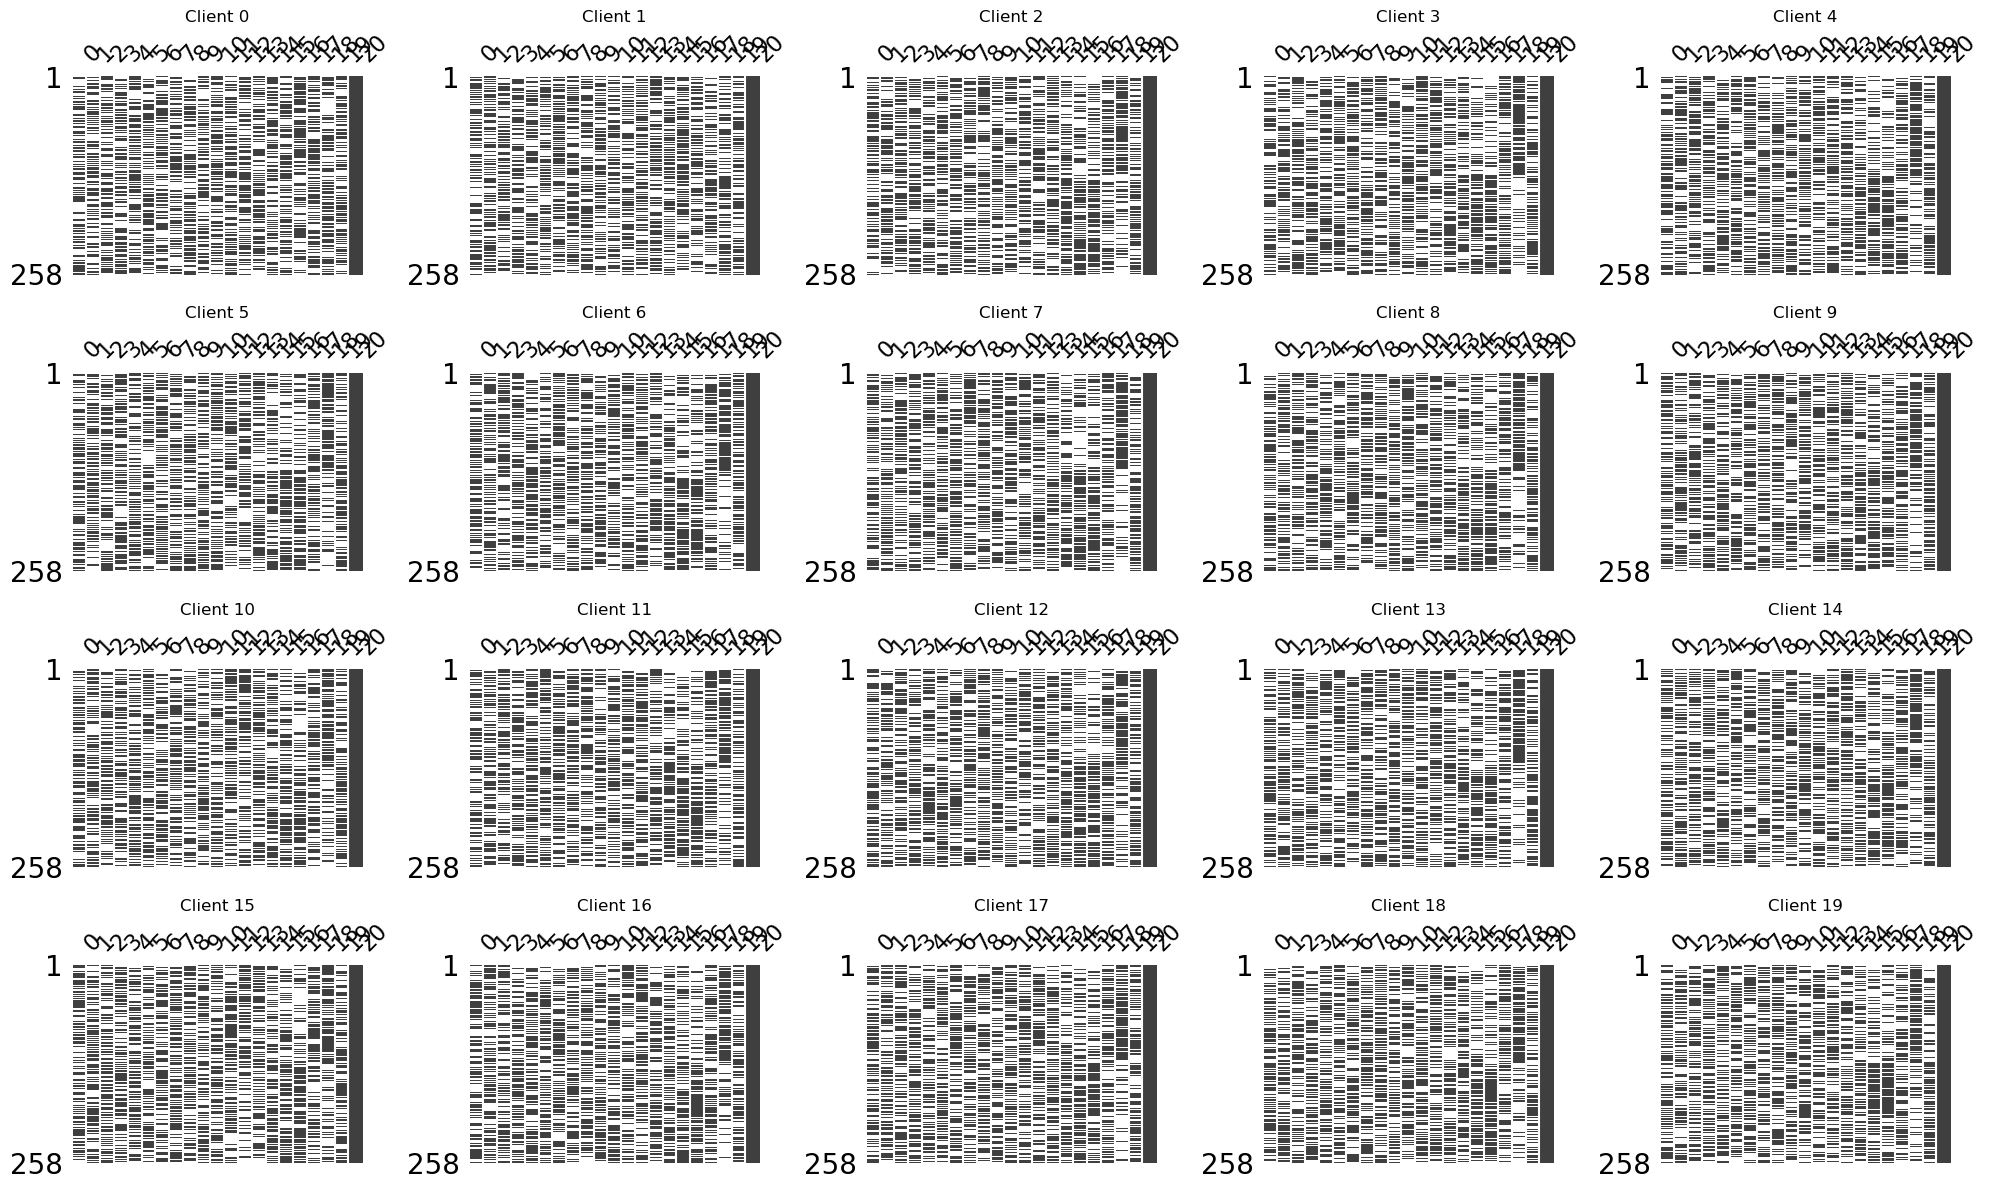

In [62]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_rl@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

visualize_ms(data_ms_clients2)

### Federated Imputation

In [63]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret5 = server.run()

2023-07-19 07:06:15.407 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 202.0360987999593


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.34850177475176286, 'imp@ws': 2.412603993664671, 'imp@sliced_ws': 0.1891858219126748}


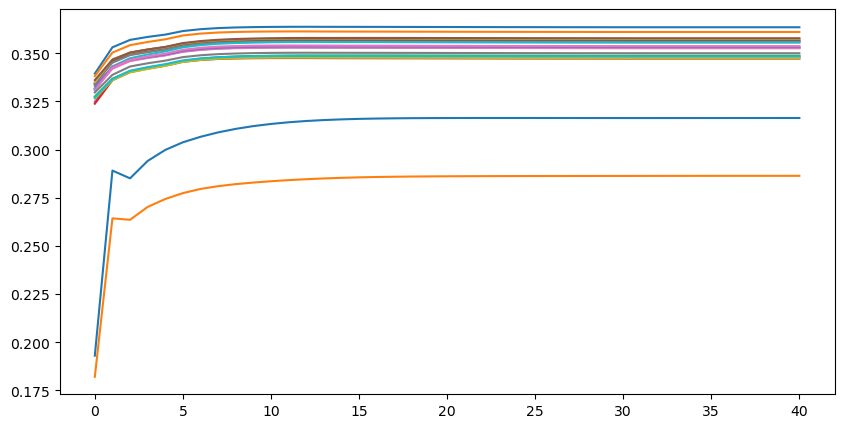

In [64]:
original_data5 = ret5['data']['origin_data'].reshape(-1, ret5['data']['origin_data'].shape[-1])
print(original_data5.shape)
centralized_data5 = ret5['data']['imputed_data'].reshape(-1, ret5['data']['imputed_data'].shape[-1])
print(centralized_data5.shape)
test_data5 = ret5['data']['test_data']
print(test_data5.shape)
print(ret5['imp_result'])

x = list(range(len(ret5['client_imp_history'])))
client_ids = list(ret5['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret5['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

### Centralized Evaluation

In [48]:
sklearn_evaluation(ret5)

Accuracy imputed centralized MLP:0.6890 (0.022)
Accuracy imputed centralized LR:0.8009 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


### Federated Evaluation Our Implementation

In [56]:
clients = {}
data_imp5 = ret5['data']['imputed_data']
missing_mask5 = ret5['data']['missing_mask']
data_true5 = ret5['data']['origin_data']
n_clients = ret5['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp5[client_id],
        missing_mask=missing_mask5[client_id],
        data_true=data_true5[client_id],
        data_test=test_data5
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data5
    )

pred_ret5 = server.prediction()

2023-07-19 06:36:08.162 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6538, test_f1: 0.6504, val_loss: 0.6823, val_accu: 0.5894, val_f1: 0.5834
2023-07-19 06:36:46.716 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7722, test_f1: 0.7719, val_loss: 0.6502, val_accu: 0.6385, val_f1: 0.6301
2023-07-19 06:37:25.079 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7544, test_f1: 0.7539, val_loss: 0.6416, val_accu: 0.6346, val_f1: 0.6212
2023-07-19 06:38:03.693 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7555, test_f1: 0.7545, val_loss: 0.6362, val_accu: 0.6471, val_f1: 0.6345
2023-07-19 06:38:41.868 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7535, test_f1: 0.752

## MNAR LR - Use complementary Models with exchaned initialization

In [65]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_rl@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left']


In [66]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret6 = server.run()

testavg


2023-07-19 07:09:39.425 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 191.37445989996195


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.13073415437559638, 'imp@ws': 0.8202753500980434, 'imp@sliced_ws': 0.06951718863294044}


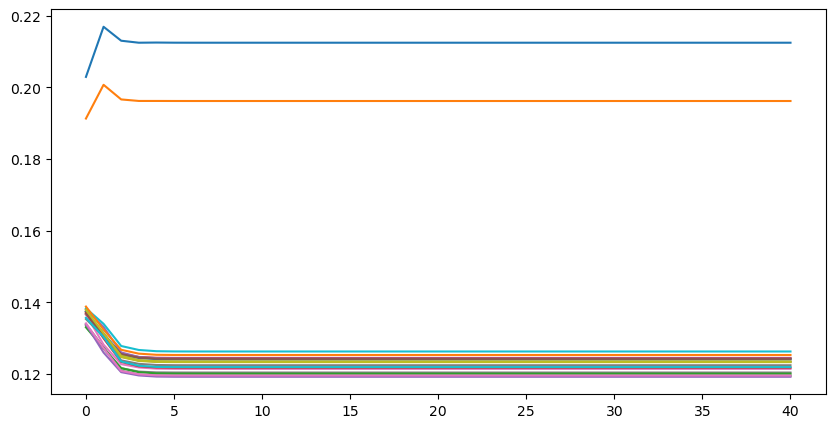

In [67]:
original_data6 = ret6['data']['origin_data'].reshape(-1, ret6['data']['origin_data'].shape[-1])
print(original_data5.shape)
centralized_data6 = ret6['data']['imputed_data'].reshape(-1, ret6['data']['imputed_data'].shape[-1])
print(centralized_data5.shape)
test_data6 = ret6['data']['test_data']
print(test_data6.shape)
print(ret6['imp_result'])

x = list(range(len(ret6['client_imp_history'])))
client_ids = list(ret6['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret6['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [52]:
sklearn_evaluation(ret6)

Accuracy imputed centralized MLP:0.8553 (0.026)
Accuracy imputed centralized LR:0.8710 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [57]:
clients = {}
data_imp = ret6['data']['imputed_data']
missing_mask = ret6['data']['missing_mask']
data_true = ret6['data']['origin_data']
n_clients = ret6['data']['origin_data'].shape[0]
test_data = ret6['data']['test_data']
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret6 = server.prediction()

2023-07-19 06:46:04.438 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7985, test_f1: 0.7975, val_loss: 0.5299, val_accu: 0.7490, val_f1: 0.7455
2023-07-19 06:46:45.293 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8440, test_f1: 0.8439, val_loss: 0.4700, val_accu: 0.7808, val_f1: 0.7790
2023-07-19 06:47:29.234 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8500, test_f1: 0.8500, val_loss: 0.4531, val_accu: 0.7962, val_f1: 0.7950
2023-07-19 06:48:11.901 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8526, test_f1: 0.8526, val_loss: 0.4443, val_accu: 0.8048, val_f1: 0.8042
2023-07-19 06:48:54.407 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8549, test_f1: 0.854

## MARY Sigmoid - more patterns

sample {'p': '0.01'}
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


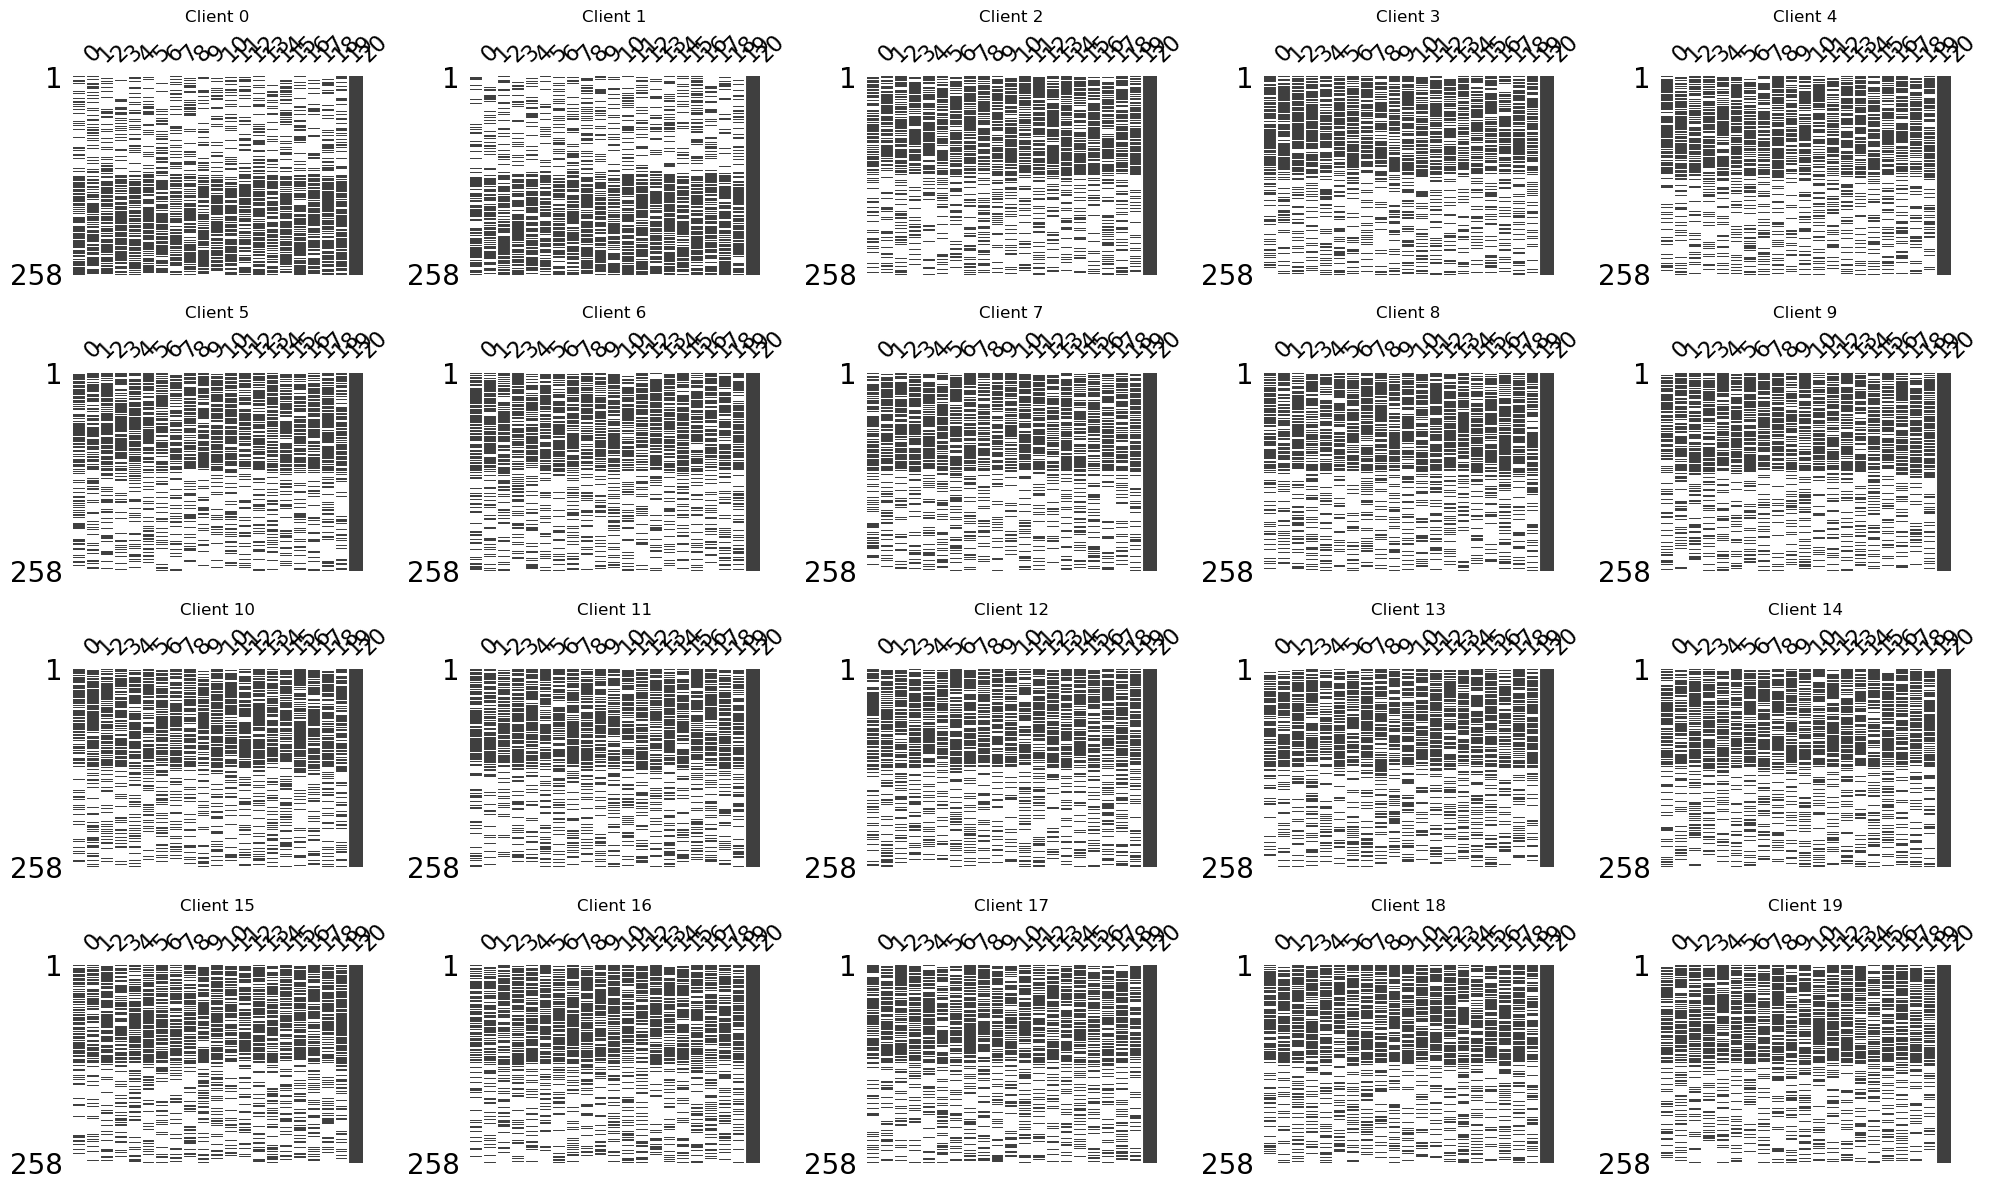

In [7]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

### Simple Averaging

In [70]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret7 = server.run()

2023-07-19 07:14:32.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 194.15533909999067


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.1980545640120416, 'imp@ws': 1.3905617092525906, 'imp@sliced_ws': 0.06793303617428166}


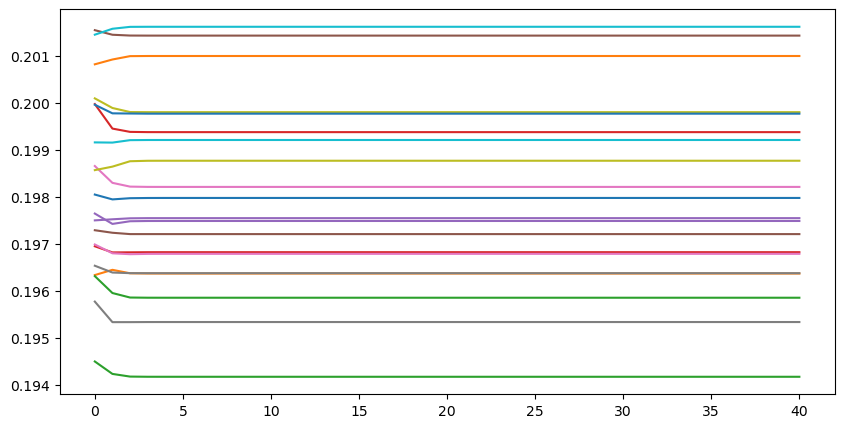

In [71]:
original_data7 = ret7['data']['origin_data'].reshape(-1, ret7['data']['origin_data'].shape[-1])
print(original_data7.shape)
centralized_data7 = ret7['data']['imputed_data'].reshape(-1, ret7['data']['imputed_data'].shape[-1])
print(centralized_data7.shape)
test_data7 = ret7['data']['test_data']
print(test_data7.shape)
print(ret7['imp_result'])

x = list(range(len(ret7['client_imp_history'])))
client_ids = list(ret7['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret7['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [72]:
sklearn_evaluation(ret7)

Accuracy imputed centralized MLP:0.6428 (0.013)
Accuracy imputed centralized LR:0.8374 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


### Complementary models

In [8]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret8 = server.run()

testavg


2023-07-19 07:25:23.198 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 204.3651833999902


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.19965491914920833, 'imp@ws': 1.2642652182331866, 'imp@sliced_ws': 0.06702093863210726}


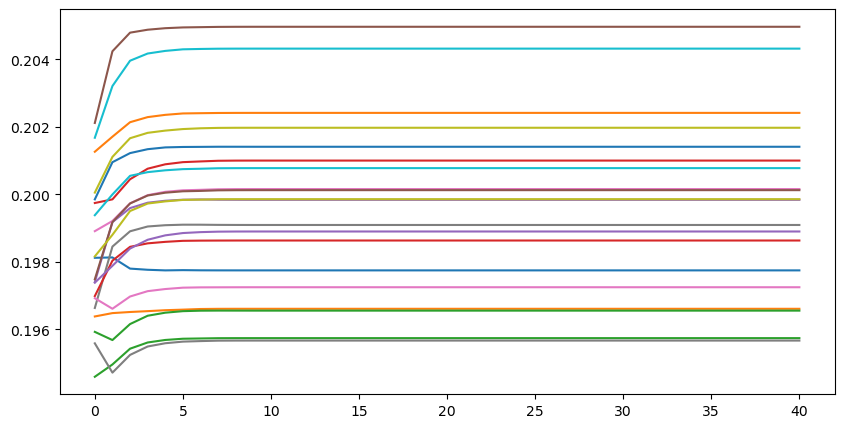

In [9]:
original_data8 = ret8['data']['origin_data'].reshape(-1, ret8['data']['origin_data'].shape[-1])
print(original_data8.shape)
centralized_data8 = ret8['data']['imputed_data'].reshape(-1, ret8['data']['imputed_data'].shape[-1])
print(centralized_data8.shape)
test_data8 = ret8['data']['test_data']
print(test_data8.shape)
print(ret8['imp_result'])

x = list(range(len(ret8['client_imp_history'])))
client_ids = list(ret8['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret8['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [10]:
sklearn_evaluation(ret8)

Accuracy imputed centralized MLP:0.6301 (0.025)
Accuracy imputed centralized LR:0.8342 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)
